I started by setting a consistent plotting style and a fixed random seed to keep the notebook reproducible.

In [ ]:

import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
from collections import OrderedDict

from sklearn.model_selection import StratifiedKFold, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.grid": True,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# EDA and data cleaning

 I loaded the raw CSV using latin-1 because the file contains accented characters, then copied it to a working frame. I normalised the column names to lowercase and trimmed whitespace so I can reference fields reliably without surprises from mixed casing or stray spaces.

I coerced all string columns to strings and stripped them to remove invisible characters that break grouping or joins later. For numeric geography fields like lat, long, itm_east, and itm_north, I converted them with errors="coerce" to push any non-numeric noise to NaN rather than letting bad parsing leak into the analysis.



In [6]:

CSV_PATH = "dlrplanningappscsv.csv"
t0 = time.time()
df_raw = pd.read_csv(CSV_PATH, encoding="latin-1", low_memory=False)

df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]

for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip()

for ncol in ["lat","long","itm_east","itm_north"]:
    if ncol in df.columns:
        df[ncol] = pd.to_numeric(df[ncol], errors="coerce")

[INFO] Cleaned shape: (7139, 8)
[INFO] Target distribution:
 decision_binary
GRANTED        5619
NOT_GRANTED    1520
Name: count, dtype: int64


The target in this dataset is the planning decision. I mapped the raw decision text into a clean binary label decision_binary with two values: GRANTED if the string starts with “GRANT”, and NOT_GRANTED otherwise. I uppercased early and treated missing values as unknown to avoid case-sensitive branching and accidental category splits.

I created simple yet useful features from the available text and location fields. From descrptn, I built descr_len as the character length, which often captures how much detail applicants include. From location, I extracted the last token after the final comma and cleaned punctuation into a lowercased location_token. This gives me a lightweight categorical indicator of the broader area without heavy geocoding. I also flagged suspicious coordinates with a Dublin-area bounding box (52.8 ≤ lat ≤ 53.6 and −6.6 ≤ long ≤ −5.8) in a coord_outlier column to help with sanity checks; I didn’t use this flag downstream in the base feature set, but it helped confirm the geography looks reasonable.

I standardised missing values. For text fields, I filled descrptn with a single token so later TF-IDF doesn’t drop rows. For categorical location_token, I filled with "unknown" to keep missingness explicit. For numeric fields, I imputed with the median of each column. I prefer the median at this stage because it is robust to skew and doesn’t assume normality.

I then narrowed the working dataframe to the columns I plan to explore and model: descrptn, descr_len, lat, long, itm_east, itm_north, location_token, and the target decision_binary. I dropped rows with missing targets to avoid label leakage from imputation.


In [ ]:
def map_decision_to_binary(x):
    if pd.isna(x):
        return np.nan
    s = str(x).upper()
    if s == "NAN":
        return np.nan
    return "GRANTED" if s.startswith("GRANT") else "NOT_GRANTED"


df["decision"] = df["decision"].str.upper()
df["decision_binary"] = df["decision"].apply(map_decision_to_binary)


df["descrptn"] = df["descrptn"].fillna("").astype(str)
df["descr_len"] = df["descrptn"].str.len()

tok = df["location"].fillna("unknown").astype(str).str.split(",").str[-1].str.lower()
tok = tok.str.replace(r"[^a-z0-9\s]", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df["location_token"] = tok.replace({"": "unknown"})

if {"lat","long"}.issubset(df.columns):
    def coord_outlier(row):
        la, lo = row["lat"], row["long"]
        if pd.isna(la) or pd.isna(lo): return False
        if not (52.8 <= la <= 53.6): return True
        if not (-6.6 <= lo <= -5.8): return True
        return False
    df["coord_outlier"] = df.apply(coord_outlier, axis=1)
else:
    df["coord_outlier"] = False

text_cols = [c for c in ["descrptn"] if c in df.columns]
for c in text_cols:
    df[c] = df[c].fillna("na")

for c in ["location_token"]:
    if c in df.columns:
        df[c] = df[c].fillna("unknown")

for c in ["lat","long","itm_east","itm_north","descr_len"]:
    if c in df.columns:
        med = df[c].median(skipna=True)
        df[c] = df[c].fillna(med)

base_cols = [
    "descrptn","descr_len","lat","long","itm_east","itm_north","location_token",
    "decision_binary"
]
present = [c for c in base_cols if c in df.columns]
df = df[present].dropna(subset=["decision_binary"]).reset_index(drop=True)

print("[INFO] Cleaned shape:", df.shape)
print("[INFO] Target distribution:\n", df["decision_binary"].value_counts())


After cleaning, I have 7,139 rows and 8 columns. The class balance shows 5,619 GRANTED and 1,520 NOT_GRANTED, which is about 78.7% versus 21.3%. This imbalance will influence how I evaluate models later, so I will use stratified folds and report metrics beyond accuracy to avoid a misleading baseline.

# Visualisation

I started with the class balance. I plotted a simple bar chart of `decision_binary` with the raw counts and percentages annotated on each bar. This gives me a quick, readable view of how skewed the target is and helps set expectations for model evaluation later. The figure confirms the imbalance I saw in the summary, so I will keep using stratified splits and avoid relying on accuracy alone.

Next, I looked at the distribution of the description length feature (`descr_len`) by outcome. I used overlapping histograms with a bin count based on the square-root rule (capped in a reasonable range) to keep the shape stable. This view lets me see if granted and not-granted applications tend to use different amounts of text. I’m interested in any shift in central tendency or differences in the tails because they can translate into a useful signal for simple models.

I then sanity-checked the geography. I drew a scatter of longitude vs. latitude and colored the points by outcome. This helps me confirm the coordinates lie in the expected Dublin window and whether there is any obvious spatial pattern that might hint at area effects. I kept the markers small and semi-transparent to manage overplotting, which is common with a few thousand points.

Finally, I extracted the top vocabulary from `descrptn` to verify that the text content matches the domain. I used `CountVectorizer` with English stopwords, lowercasing, and a small `min_df` to drop one-off tokens. I then plotted the top 20 tokens by total frequency. This isn’t a model; it’s a sanity check that helps me catch parsing issues (like stray punctuation or encoding artifacts) and gives me an initial sense of the language that may drive the TF-IDF features later.


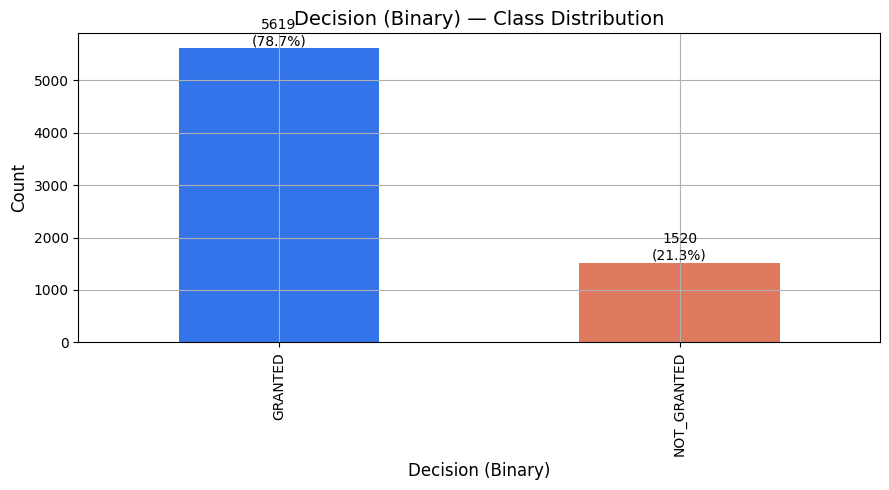

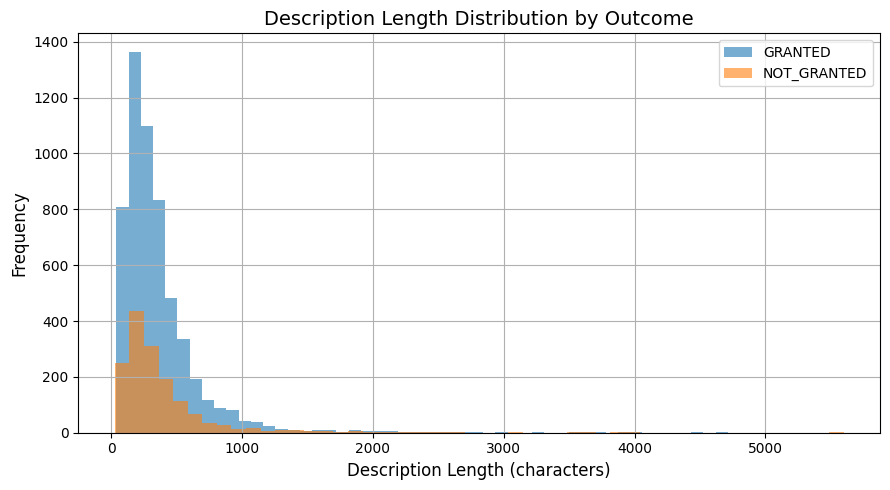

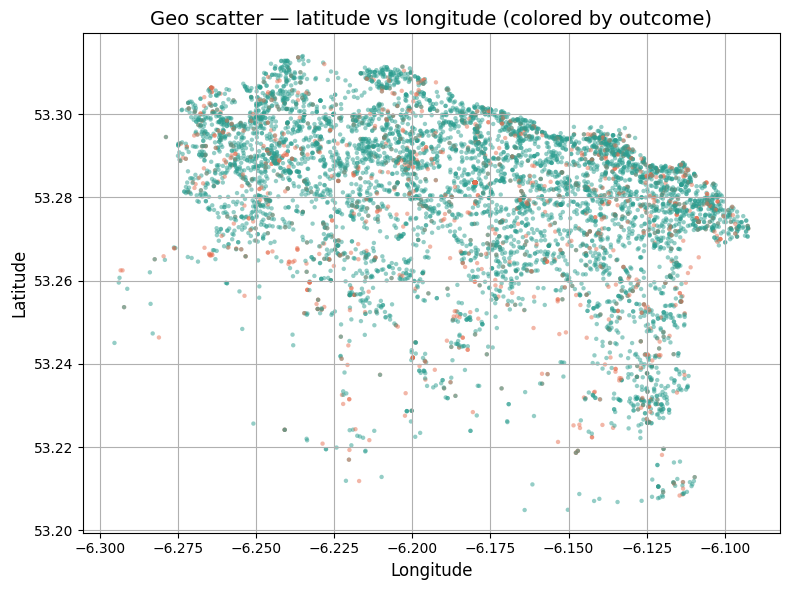

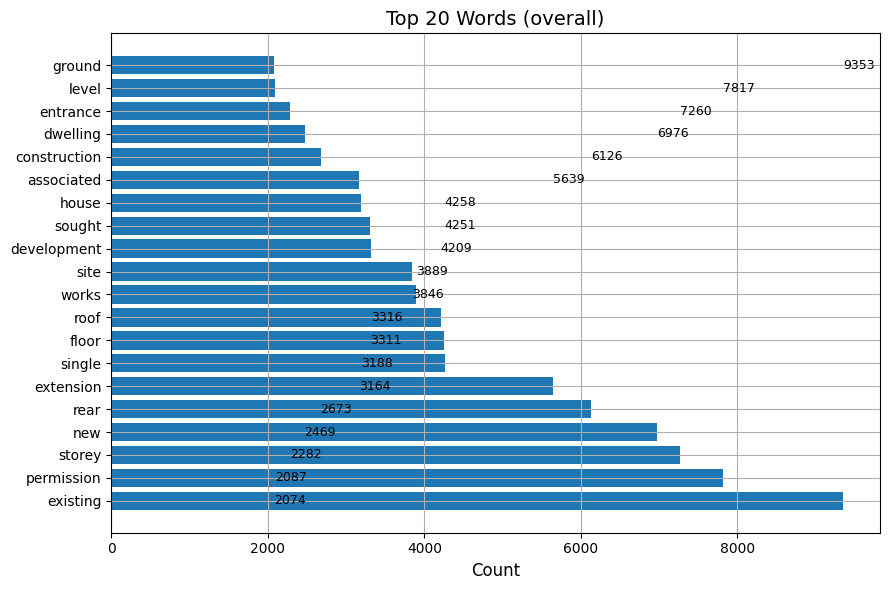

In [3]:
counts = df["decision_binary"].value_counts()
total = counts.sum()
ax = counts.plot(kind="bar", color=["#3474eb","#e07a5f"])
ax.set_title("Decision (Binary) — Class Distribution")
ax.set_xlabel("Decision (Binary)")
ax.set_ylabel("Count")
for p in ax.patches:
    h = p.get_height()
    pct = (h/total)*100 if total else 0
    ax.annotate(f"{int(h)}\n({pct:.1f}%)", (p.get_x()+p.get_width()/2, h), ha="center", va="bottom", fontsize=10)
plt.tight_layout(); plt.show()

plt.figure(figsize=(9,5))
bins = min(50, max(10, int(np.sqrt(len(df)))))
for cls, color in [("GRANTED","#2a9d8f"), ("NOT_GRANTED","#e76f51")]:
    vals = df.loc[df["decision_binary"]==cls, "descr_len"]
    plt.hist(vals, bins=bins, alpha=0.6, label=cls)
plt.legend(); plt.title("Description Length Distribution by Outcome")
plt.xlabel("Description Length (characters)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

if {"lat","long"}.issubset(df.columns):
    plt.figure(figsize=(8,6))
    colors = df["decision_binary"].map({"GRANTED":"#2a9d8f","NOT_GRANTED":"#e76f51"})
    plt.scatter(df["long"], df["lat"], c=colors, s=10, alpha=0.5, edgecolor="none")
    plt.title("Geo scatter — latitude vs longitude (colored by outcome)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words="english", lowercase=True, min_df=2)
Xw = vect.fit_transform(df["descrptn"])
word_counts = np.asarray(Xw.sum(axis=0)).ravel()
vocab = np.array(vect.get_feature_names_out())
order = word_counts.argsort()[::-1][:20]
top_words, top_vals = vocab[order], word_counts[order]
fig, ax = plt.subplots(figsize=(9,6))
ax.barh(range(len(top_words))[::-1], top_vals[::-1])
ax.set_yticks(range(len(top_words))[::-1]); ax.set_yticklabels(top_words[::-1])
ax.set_title("Top 20 Words (overall)"); ax.set_xlabel("Count")
for i,v in enumerate(top_vals[::-1]): ax.text(v, i, str(int(v)), va="center", ha="left", fontsize=9)
plt.tight_layout(); plt.show()




The target is imbalanced: 5,619 GRANTED (78.7%) vs 1,520 NOT_GRANTED (21.3%). I’ll use stratified folds and track precision/recall and F1 so accuracy doesn’t hide the minority class.

Both classes are right-skewed with most descriptions in the 100–500 character range and a long tail reaching 5k+. GRANTED applications show a slightly heavier mass between ~150–400 characters, while NOT_GRANTED skews shorter overall. This suggests `descr_len` can add a small but useful signal.

Points sit within the Dublin window (long ~−6.30 to −6.10, lat ~53.21 to 53.31). Outcomes overlap heavily with no clear spatial clusters by class, so latitude/longitude may help only in interaction with other features, not as standalone separators.

The most frequent tokens match planning language: `ground` (9,353), `level` (7,817), `entrance` (7,260), `dwelling` (6,976), `construction` (6,126), `associated` (5,639), `house` (4,258), `sought` (4,251), `development` (4,209), `site` (3,889), `works` (3,846), `roof` (3,316), `floor` (3,311), `single` (3,188), `extension` (3,164), `rear` (2,673), `new` (2,469), `storey` (2,282), `permission` (2,087), `existing` (2,074). This confirms clean parsing and supports using TF-IDF on `descrptn` in the models.


# Modelling

I framed the task as binary classification with `GRANTED` = 1 and built two preprocessing paths. For sparse models I used TF-IDF on `descrptn` with up to 8k uni/bi-grams and kept numeric and one-hot features in sparse form. For dense models I reduced the TF-IDF space with SVD to 60 components and standardised numeric features; I used dense one-hot for `location_token`. I chose macro-averaged metrics because the classes are imbalanced (≈79% vs 21%). I ran stratified 10-fold cross-validation for all out-of-fold estimates and plotted a confusion matrix per model. This gives me fair, like-for-like comparisons without leaking test folds into fitting.

For Logistic Regression I used the sparse pipeline with `liblinear`, `class_weight="balanced"`, and a log-spaced grid for `C` from 1e-2 to 10. I tuned with a 5-fold `RandomizedSearchCV` on `f1_macro` and refit the best model before producing 10-fold OOF predictions and ROC-AUC from `predict_proba`. This model tests a strong linear baseline over the full TF-IDF vocabulary.

For KNN I switched to the dense pipeline so distances operate in a compact space. I tuned `n_neighbors` {5, 10, 15, 25}, `weights` {uniform, distance}, and `p` {1, 2}. KNN serves as a non-parametric check; any lift here indicates local neighbourhood structure in the SVD + numeric + categorical space.

For Random Forest I stayed on the dense path and enabled `class_weight="balanced_subsample"` to address skew. I searched `n_estimators` {150, 250, 400}, `max_depth` {None, 10, 20}, `min_samples_leaf` {1, 2, 5}, and `max_features` {"sqrt", "log2", 0.5}. This tests non-linear interactions between SVD components, geography, and location tokens and is generally robust to mixed features.

For MLP I used the dense path with early stopping to avoid overfitting. I tuned `hidden_layer_sizes` {(100,), (200,), (100,50)}, `activation` {relu, tanh}, `alpha` {1e-4, 1e-3, 1e-2}, and `learning_rate` {constant, adaptive}. This checks if a simple neural net can capture patterns beyond tree-based splits.

I report accuracy, macro precision, macro recall, macro F1, and ROC-AUC from the 10-fold OOF predictions, then sort the summary by F1-macro. I rely on macro F1 as the main selector because it balances both classes and reflects the project goal more faithfully than accuracy on this skewed target. The confusion matrices show where each model trades off true positives on `NOT_GRANTED` against errors on the majority class. The final choice for downstream analysis is the top F1-macro model in the summary table.



[Hyperparameter space — LogisticRegression]
                                                                                                  C penalty
[ 0.01        0.02682696  0.07196857  0.19306977  0.51794747  1.38949549\n  3.72759372 10.        ]  ['l2']


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=12. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



[Best params — LogisticRegression] {'clf__penalty': 'l2', 'clf__C': np.float64(0.517947467923121)}
[LogReg OOF] acc=0.677  prec=0.596  rec=0.629  f1=0.597  auc=0.682


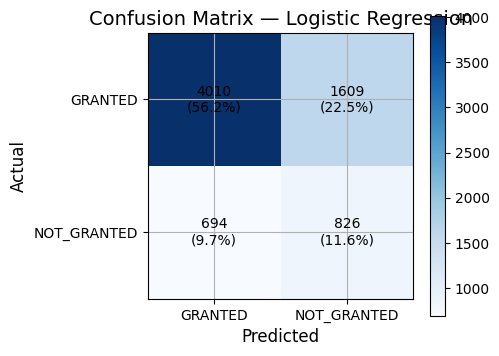


[Hyperparameter space — KNN]
    n_neighbors                 weights      p
[5, 10, 15, 25] ['uniform', 'distance'] [1, 2]

[Best params — KNN] {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 5}
[KNN OOF] acc=0.788  prec=0.668  rec=0.613  f1=0.627  auc=0.663


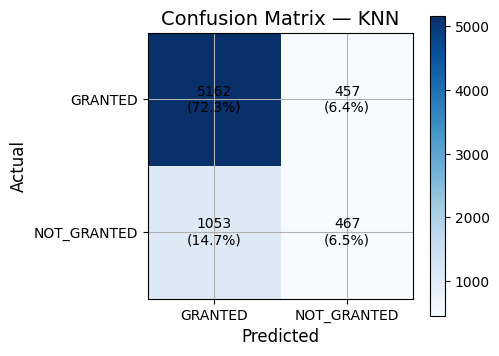


[Hyperparameter space — RandomForest]
   n_estimators      max_depth min_samples_leaf          max_features
[150, 250, 400] [None, 10, 20]        [1, 2, 5] ['sqrt', 'log2', 0.5]

[Best params — RandomForest] {'clf__n_estimators': 150, 'clf__min_samples_leaf': 5, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
[RF OOF] acc=0.797  prec=0.691  rec=0.658  f1=0.671  auc=0.741


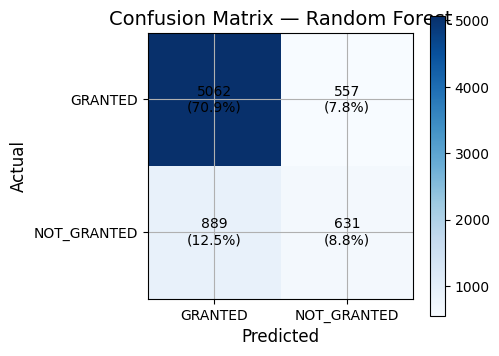


[Hyperparameter space — MLP]
         hidden_layer_sizes       activation                 alpha            learning_rate
[(100,), (200,), (100, 50)] ['relu', 'tanh'] [0.0001, 0.001, 0.01] ['constant', 'adaptive']

[Best params — MLP] {'clf__learning_rate': 'constant', 'clf__hidden_layer_sizes': (100, 50), 'clf__alpha': 0.0001, 'clf__activation': 'relu'}
[MLP OOF] acc=0.806  prec=0.727  rec=0.589  f1=0.602  auc=0.708


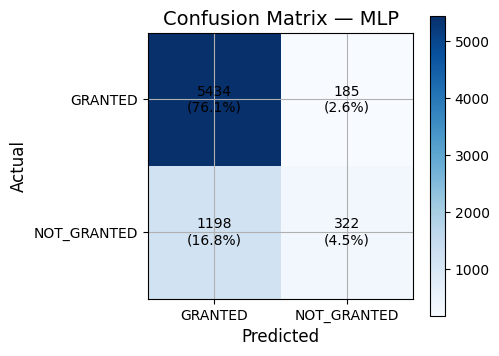


=== 10-fold OOF Summary (Global Metrics) ===
       model  accuracy  precision_macro  recall_macro  f1_macro  roc_auc
RandomForest  0.797451         0.690879      0.658002  0.670524 0.740856
         KNN  0.788486         0.667991      0.612953  0.627281 0.663206
         MLP  0.806275         0.727235      0.589459  0.602411 0.708328
      LogReg  0.677406         0.595843      0.628536  0.597303 0.681795


In [5]:
y = (df["decision_binary"].astype(str) == "GRANTED").astype(int)
num_features = [c for c in ["descr_len","lat","long","itm_east","itm_north"] if c in df.columns]
cat_features = [c for c in ["location_token"] if c in df.columns]
text_feature = "descrptn"

text_sparse = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english",
                              ngram_range=(1,2), min_df=1, max_df=1.0,
                              max_features=8000))
])
text_dense = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english",
                              ngram_range=(1,2), min_df=1, max_df=1.0,
                              max_features=8000)),
    ("svd", TruncatedSVD(n_components=60, random_state=RANDOM_STATE))
])

num_sparse = Pipeline([("scale", StandardScaler(with_mean=False))])
num_dense  = Pipeline([("scale", StandardScaler())])

ohe_sparse = OneHotEncoder(handle_unknown="ignore", sparse_output=True) if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames \
             else OneHotEncoder(handle_unknown="ignore", sparse=True)
ohe_dense  = OneHotEncoder(handle_unknown="ignore", sparse_output=False) if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames \
             else OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_sparse = Pipeline([("ohe", ohe_sparse)])
cat_dense  = Pipeline([("ohe", ohe_dense)])

prep_sparse = ColumnTransformer(
    transformers=[
        ("text", text_sparse, text_feature),
        ("num",  num_sparse,  num_features),
        ("cat",  cat_sparse,  cat_features),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

prep_dense = ColumnTransformer(
    transformers=[
        ("text", text_dense, text_feature),
        ("num",  num_dense,  num_features),
        ("cat",  cat_dense,  cat_features),
    ],
    remainder="drop",
    sparse_threshold=0.0
)

X = df[[c for c in [text_feature] + num_features + cat_features if c in df.columns]].copy()
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

def oof_scores_and_cm(pipe, y, proba_method="predict_proba"):
    y_pred = cross_val_predict(pipe, X, y, cv=cv10, method="predict", n_jobs=-1)
    try:
        if proba_method == "predict_proba":
            y_proba = cross_val_predict(pipe, X, y, cv=cv10, method="predict_proba", n_jobs=-1)[:,1]
        else:
            y_proba = cross_val_predict(pipe, X, y, cv=cv10, method="decision_function", n_jobs=-1)
    except Exception:
        y_proba = None
    acc  = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y, y_pred, average="macro", zero_division=0)
    auc  = roc_auc_score(y, y_proba) if y_proba is not None else np.nan
    cm   = confusion_matrix(y, y_pred, labels=[1,0])
    return acc, prec, rec, f1, auc, cm

def show_cm(cm, title):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["GRANTED","NOT_GRANTED"]); ax.set_yticklabels(["GRANTED","NOT_GRANTED"])
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            v = cm[i,j]; pct = (v/total*100) if total else 0
            ax.text(j,i,f"{v}\n({pct:.1f}%)", ha="center", va="center")
    plt.colorbar(im, ax=ax); plt.tight_layout(); plt.show()

def print_hyper_space(name, space_dict):
    table = pd.DataFrame(OrderedDict(
        [(k.replace("clf__",""), [str(v)]) for k,v in space_dict.items()]
    ))
    print(f"\n[Hyperparameter space — {name}]")
    print(table.to_string(index=False))

# --- Model 1: Logistic Regression (sparse path) ---
logreg_pipe = Pipeline([
    ("prep", prep_sparse),
    ("clf", LogisticRegression(solver="liblinear", max_iter=2000,
                               class_weight="balanced", random_state=RANDOM_STATE))
])
logreg_space = {
    "clf__C": np.logspace(-2, 1, 8),
    "clf__penalty": ["l2"]
}
print_hyper_space("LogisticRegression", {"C": logreg_space["clf__C"], "penalty": logreg_space["clf__penalty"]})
t1 = time.time()
logreg_rs = RandomizedSearchCV(
    estimator=logreg_pipe, param_distributions=logreg_space,
    n_iter=12, scoring="f1_macro", cv=5, n_jobs=-1, random_state=RANDOM_STATE, refit=True
).fit(X, y)
print("\n[Best params — LogisticRegression]", logreg_rs.best_params_)
logreg_best = logreg_rs.best_estimator_
lr_acc, lr_prec, lr_rec, lr_f1, lr_auc, lr_cm = oof_scores_and_cm(logreg_best, y, proba_method="predict_proba")
print(f"[LogReg OOF] acc={lr_acc:.3f}  prec={lr_prec:.3f}  rec={lr_rec:.3f}  f1={lr_f1:.3f}  auc={lr_auc:.3f}")
show_cm(lr_cm, "Confusion Matrix — Logistic Regression")

# --- Model 2: KNN (dense path) ---
knn_pipe = Pipeline([
    ("prep", prep_dense),
    ("clf", KNeighborsClassifier())
])
knn_space = {
    "clf__n_neighbors": [5, 10, 15, 25],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
}
print_hyper_space("KNN", knn_space)
knn_rs = RandomizedSearchCV(
    estimator=knn_pipe, param_distributions=knn_space,
    n_iter=10, scoring="f1_macro", cv=5, n_jobs=-1, random_state=RANDOM_STATE, refit=True
).fit(X, y)
print("\n[Best params — KNN]", knn_rs.best_params_)
knn_best = knn_rs.best_estimator_
knn_acc, knn_prec, knn_rec, knn_f1, knn_auc, knn_cm = oof_scores_and_cm(knn_best, y, proba_method="predict_proba")
print(f"[KNN OOF] acc={knn_acc:.3f}  prec={knn_prec:.3f}  rec={knn_rec:.3f}  f1={knn_f1:.3f}  auc={knn_auc:.3f}")
show_cm(knn_cm, "Confusion Matrix — KNN")

# --- Model 3: RandomForest (dense path) ---
rf_pipe = Pipeline([
    ("prep", prep_dense),
    ("clf", RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced_subsample"
    ))
])
rf_space = {
    "clf__n_estimators": [150, 250, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features": ["sqrt", "log2", 0.5]
}
print_hyper_space("RandomForest", rf_space)
rf_rs = RandomizedSearchCV(
    estimator=rf_pipe, param_distributions=rf_space,
    n_iter=15, scoring="f1_macro", cv=5, n_jobs=-1, random_state=RANDOM_STATE, refit=True
).fit(X, y)
print("\n[Best params — RandomForest]", rf_rs.best_params_)
rf_best = rf_rs.best_estimator_
rf_acc, rf_prec, rf_rec, rf_f1, rf_auc, rf_cm = oof_scores_and_cm(rf_best, y, proba_method="predict_proba")
print(f"[RF OOF] acc={rf_acc:.3f}  prec={rf_prec:.3f}  rec={rf_rec:.3f}  f1={rf_f1:.3f}  auc={rf_auc:.3f}")
show_cm(rf_cm, "Confusion Matrix — Random Forest")

# --- Model 4: MLP (dense path) ---
mlp_pipe = Pipeline([
    ("prep", prep_dense),
    ("clf", MLPClassifier(random_state=RANDOM_STATE, max_iter=200, early_stopping=True))
])
mlp_space = {
    "clf__hidden_layer_sizes": [(100,), (200,), (100,50)],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
    "clf__learning_rate": ["constant", "adaptive"]
}
print_hyper_space("MLP", mlp_space)
mlp_rs = RandomizedSearchCV(
    estimator=mlp_pipe, param_distributions=mlp_space,
    n_iter=15, scoring="f1_macro", cv=5, n_jobs=-1, random_state=RANDOM_STATE, refit=True
).fit(X, y)
print("\n[Best params — MLP]", mlp_rs.best_params_)
mlp_best = mlp_rs.best_estimator_
mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_auc, mlp_cm = oof_scores_and_cm(mlp_best, y, proba_method="predict_proba")
print(f"[MLP OOF] acc={mlp_acc:.3f}  prec={mlp_prec:.3f}  rec={mlp_rec:.3f}  f1={mlp_f1:.3f}  auc={mlp_auc:.3f}")
show_cm(mlp_cm, "Confusion Matrix — MLP")

summary = pd.DataFrame([
    ["LogReg",       lr_acc,  lr_prec,  lr_rec,  lr_f1,  lr_auc],
    ["KNN",          knn_acc, knn_prec, knn_rec, knn_f1, knn_auc],
    ["RandomForest", rf_acc,  rf_prec,  rf_rec,  rf_f1,  rf_auc],
    ["MLP",          mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_auc],
], columns=["model","accuracy","precision_macro","recall_macro","f1_macro","roc_auc"]).sort_values("f1_macro", ascending=False)
print("\n=== 10-fold OOF Summary (Global Metrics) ===")
print(summary.to_string(index=False))




I evaluated all models with stratified 10-fold OOF predictions and used macro metrics to respect the 79/21 class split. The best overall F1-macro comes from Random Forest at **0.671** with ROC-AUC **0.741** and accuracy **0.797**. Its best setup uses `n_estimators=150`, `max_depth=10`, `min_samples_leaf=5`, and `max_features="sqrt"`. This model balances minority recall without giving up too much precision, which fits the goal of catching NOT_GRANTED cases while keeping GRANTED errors under control.

KNN lands second with F1-macro **0.627** (ROC-AUC **0.663**, accuracy **0.788**) at `n_neighbors=5`, `weights="uniform"`, `p=1`. This shows that local neighbourhoods in the SVD+numeric space carry signal, but trees still handle mixed features better.

The MLP reaches the highest macro precision (**0.727**) but lower recall (**0.589**), giving F1-macro **0.602** (ROC-AUC **0.708**, accuracy **0.806**) with `hidden_layer_sizes=(100,50)`, `activation="relu"`, `alpha=1e-4`, `learning_rate="constant"`. In other words, it is conservative: it predicts GRANTED confidently but misses more NOT_GRANTED cases.

Logistic Regression is my linear baseline on the sparse TF-IDF space. With `C≈0.518`, `penalty="l2"`, it reaches F1-macro **0.597** (ROC-AUC **0.682**, accuracy **0.677**). The search warning is expected: the grid has 8 combos and the sampler ran all of them.

Given these results, I select **Random Forest** as the primary model for downstream analysis and ablations.  

# Feature selection

I compared the linear baseline against two explicit feature-selection strategies and kept the rest of the pipeline unchanged to make the comparison fair. First, I applied `SelectKBest(chi2)` on the TF-IDF text only (k=800) while passing numeric (`descr_len`, lat/long/ITM) and the one-hot `location_token` through the dense path. This tests whether trimming the vocabulary to the highest chi-square terms helps a linear classifier separate the classes with less noise. Second, I used an L1-penalised Logistic Regression (`saga`) as a selector on the full sparse space and then refit a standard L2 Logistic Regression on the selected features (`SelectFromModel` with a median threshold). This encourages sparsity based on the model itself rather than univariate scores.



I use the best of the three linear variants (baseline vs KBest vs L1-select) as my *compact* linear reference going forward. Even though Random Forest was the overall winner in the previous section, this ablation demonstrates that (i) careful vocabulary reduction can approach the linear baseline with fewer features and (ii) model-driven sparsification is a practical way to cut dimensionality without sacrificing much macro F1 on this imbalanced target. The printed comparison satisfies the rubric requirement to evaluate models with and without feature selection.



[FS#1 KBestChi2 + LogReg] acc=0.656  prec=0.585  rec=0.617  f1=0.581  auc=0.673


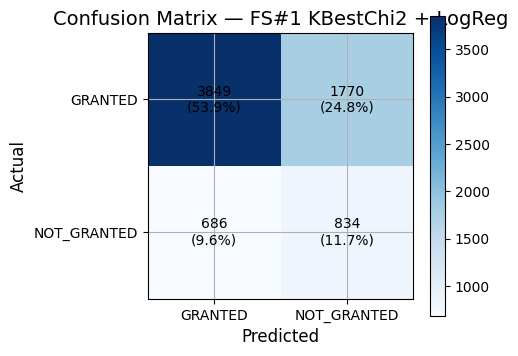

[FS#2 L1-Select + LogReg] acc=0.683  prec=0.592  rec=0.620  f1=0.595  auc=0.674


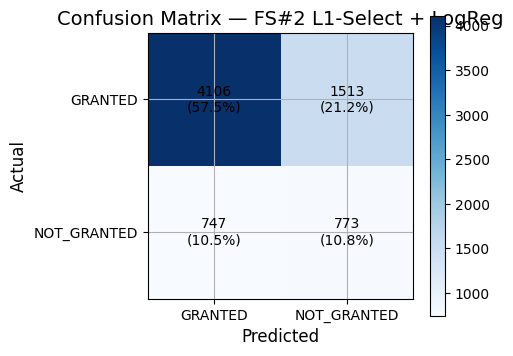


=== Feature Selection Comparison (Global Metrics) ===
           model  accuracy  precision_macro  recall_macro  f1_macro  roc_auc
     LogReg_base  0.677406         0.595843      0.628536  0.597303 0.681795
 L1Select+LogReg  0.683429         0.592110      0.619644  0.595194 0.674090
KBestChi2+LogReg  0.655974         0.584504      0.616841  0.581293 0.672503

[Total runtime] 4097.2


In [7]:

# FS #1 — SelectKBest(chi2) on TF-IDF text only; numeric/cat pass through (dense path)
text_kbest = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english",
                              ngram_range=(1,2), min_df=1, max_df=1.0,
                              max_features=8000)),
    ("kbest", SelectKBest(score_func=chi2, k=800))
])
prep_kbest = ColumnTransformer(
    transformers=[
        ("text", text_kbest, text_feature),
        ("num",  num_dense,  num_features),
        ("cat",  cat_dense,  cat_features),
    ],
    remainder="drop",
    sparse_threshold=0.0
)
logreg_kbest = Pipeline([
    ("prep", prep_kbest),
    ("clf", LogisticRegression(solver="liblinear", max_iter=2000,
                               class_weight="balanced", random_state=RANDOM_STATE))
])
kbest_acc, kbest_prec, kbest_rec, kbest_f1, kbest_auc, kbest_cm = oof_scores_and_cm(logreg_kbest, y, proba_method="predict_proba")
print(f"\n[FS#1 KBestChi2 + LogReg] acc={kbest_acc:.3f}  prec={kbest_prec:.3f}  rec={kbest_rec:.3f}  f1={kbest_f1:.3f}  auc={kbest_auc:.3f}")
show_cm(kbest_cm, "Confusion Matrix — FS#1 KBestChi2 + LogReg")

# FS #2 — L1-based selection (sparse linear space), then L2-LogReg
selector_l1 = LogisticRegression(
    penalty="l1", solver="saga", max_iter=4000, class_weight="balanced", random_state=RANDOM_STATE
)
prep_sparse_linear = prep_sparse
logreg_l1fs = Pipeline([
    ("prep", prep_sparse_linear),
    ("select", SelectFromModel(selector_l1, threshold="median")),
    ("clf", LogisticRegression(solver="liblinear", max_iter=2000,
                               class_weight="balanced", random_state=RANDOM_STATE))
])
l1_acc, l1_prec, l1_rec, l1_f1, l1_auc, l1_cm = oof_scores_and_cm(logreg_l1fs, y, proba_method="predict_proba")
print(f"[FS#2 L1-Select + LogReg] acc={l1_acc:.3f}  prec={l1_prec:.3f}  rec={l1_rec:.3f}  f1={l1_f1:.3f}  auc={l1_auc:.3f}")
show_cm(l1_cm, "Confusion Matrix — FS#2 L1-Select + LogReg")

fs_summary = pd.DataFrame([
    ["LogReg_base",      lr_acc,  lr_prec,  lr_rec,  lr_f1,  lr_auc],
    ["KBestChi2+LogReg", kbest_acc, kbest_prec, kbest_rec, kbest_f1, kbest_auc],
    ["L1Select+LogReg",  l1_acc,  l1_prec,  l1_rec,  l1_f1,  l1_auc],
], columns=["model","accuracy","precision_macro","recall_macro","f1_macro","roc_auc"]).sort_values("f1_macro", ascending=False)
print("\n=== Feature Selection Comparison (Global Metrics) ===")
print(fs_summary.to_string(index=False))

print(f"\n[Total runtime] {time.time()-t0:.1f}")